In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from pathlib import Path

from train_vae import train_vae
from train_gc import train_gc2
from train_classifier import train_classifier
from prepare_proben1 import diabetes as load_data
from utils import seed_everything

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KernelDensity

In [2]:
# set seed
seed = 42
# set cudnn backend to be deterministic
torch.backends.cudnn.deterministic = True

### Models

In [3]:
class Encoder(nn.Sequential):
    def __init__(self, z_dim, n_feat: int):
        self.z_dim = z_dim
        nn.Sequential.__init__(self,
            nn.Linear(n_feat, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2 * z_dim)
        )
    def forward(self, x):
        mean_variance = nn.Sequential.forward(self, x)
        mean, log_variance = mean_variance[..., :self.z_dim], mean_variance[..., self.z_dim:]
        # actually computes the log of the variance
        return mean, log_variance

class Decoder(nn.Sequential):
    def __init__(self, z_dim, n_feat: int):
        nn.Sequential.__init__(self,
            nn.Linear(z_dim, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, n_feat),
            nn.Sigmoid(),
        )
    def forward(self, z):
        return nn.Sequential.forward(self, z)

class VAE(nn.Module):
    def __init__(self, z_dim, in_feat: int):
        nn.Module.__init__(self)
        self.encoder = Encoder(z_dim, n_feat=in_feat)
        self.decoder = Decoder(z_dim, n_feat=in_feat)
    def forward(self, x):
        # encode
        mean, variance_log = self.encoder(x)
        # sample from encoding
        if self.training:
            eps = torch.empty_like(variance_log).normal_()
            z = eps * (variance_log / 2).exp() + mean
        else:
            # in evaluation use the mean
            z = mean
        # decode from sample
        x_ = self.decoder(z)
        return x_, mean, variance_log

class GenerativeClassifier(nn.Sequential):
    def __init__(self, in_feat: int, N: int, M: int, K: int):
        nn.Sequential.__init__(self, 
            # input size: in_feat
            nn.Linear(in_feat, N),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(N),
            nn.Dropout(0.1, inplace=True),
            # state size: N
            nn.Linear(N, M),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(M),
            nn.Dropout(0.1, inplace=True),
            # state size: M
            nn.Linear(M, K),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(K),
            nn.Dropout(0.1, inplace=True),
            # state size: K
            nn.Linear(K, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return nn.Sequential.forward(self, x)

class CNN(nn.Sequential):
    def __init__(self, in_feat: int, out_feat: int, N: int, M: int, K: int):
        nn.Sequential.__init__(self, 
            # input size: in_feat
            nn.Linear(in_feat, N),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(N),
            nn.Dropout(0.1, inplace=True),
            # state size: N
            nn.Linear(N, M),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(M),
            nn.Dropout(0.1, inplace=True),
            # state size: M
            nn.Linear(M, K),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(K),
            nn.Dropout(0.1, inplace=True),
            # state size: K
            nn.Linear(K, out_feat),
            nn.LogSoftmax(dim=-1),
        )
    def forward(self, x):
        return nn.Sequential.forward(self, x)

### Hyperparameters

In [4]:
# data hyperparameters
# n_originals_per_class = 5     # number of original samples per class to use for training
n_generated_total = 100         # number of generated samples per class to use for training
# vae hyperparamters
vae_z_dim = 2                   # latent space dimension for vae
vae_training_steps = 2000       # number of training steps for the vae
vae_beta = 5.0                  # beta parameter of the kl-loss term
vae_batch_size = 2              # batch size for vae training
# gc hyperparameters
gc_training_steps = 800         # number of training steps for the gan
gc_batch_size = 16              # batch size for gan training
gc_std = 0.01                   # std used for generating noise examples
# cnn model hyperparameters
cnn_training_steps = 600        # number of training steps for the cnn
cnn_batch_size = 32             # batch size for cnn training
cnn_eval_interval = 20          # interval to evaluate model during training
# cuda
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
# plotting directory
plot_root = Path(f"diabetes_case")
plot_root.mkdir(parents=True, exist_ok=True)

Using device: cuda:0


### Data Preparation

In [5]:
seed_everything(seed)
# load data, labels and shapes
data, labels, shapes = load_data()
# stratified cross-validation splitter
skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
# processing of a splitted dataset fold
def process_skf(train_index, test_index):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # separate dataset into the different classes
    train_per_label = [x_train[y_train == i] for i in range(shapes["out_feat"])]
    # randomly choose a number of samples for training set
    train_per_label = [X[np.random.permutation(X.shape[0]), ...] for X in train_per_label]

    # compute examples needed for balancing
    # x is the proportion of class i in the dataset
    x = np.array([count / y_train.shape[0] for count in [X.shape[0] for X in train_per_label]])
    # L is the amount of data for each class that has to be generated
    n_generated_per_class = np.round((1 - x) / (shapes["out_feat"] - 1) * n_generated_total).astype('int')
    # n_generated_per_class = np.round(x * n_generated_total).astype('int')
    # n_generated_per_class = [n_generated_total] * shapes["out_feat"]
    print(f"n_generated_per_class = {n_generated_per_class}")

    # convert testing data to tensors
    x_test = torch.FloatTensor(x_test)
    y_test = torch.LongTensor(y_test)
    
    return train_per_label, x_test, y_test, n_generated_per_class

In [6]:
all_f1_weighted_orig, all_f1_weighted_gen, all_f1_weighted_gen_gc = [], [], []

train_index, test_index = next(iter(skf.split(data, labels)))

# create plotting directory
plot_dir = plot_root
plot_dir.mkdir(exist_ok=True)
# prepare datasets
train_per_label, x_test, y_test, n_generated_per_class = process_skf(train_index, test_index)

n_generated_per_class = [35 65]


### Training the VAE Models

In [7]:
seed_everything(seed)
# create one VAE model for each class
vae_per_label = [VAE(z_dim=vae_z_dim, in_feat=shapes["in_feat"]) for _ in range(len(train_per_label))]
vae_per_label = train_vae(
    train_per_label,
    vae_per_label,
    vae_training_steps,
    vae_batch_size,
    vae_beta,
    device,
)

  1%|          | 22/2000 [00:00<00:09, 209.01it/s, r-loss=485, kl-loss=0.0186]  

k=0	 r-loss: 401.836	 kl-loss: 0.550


k=1	 r-loss: 491.520	 kl-loss: 1.023


Visualize a few examples

[35 65]


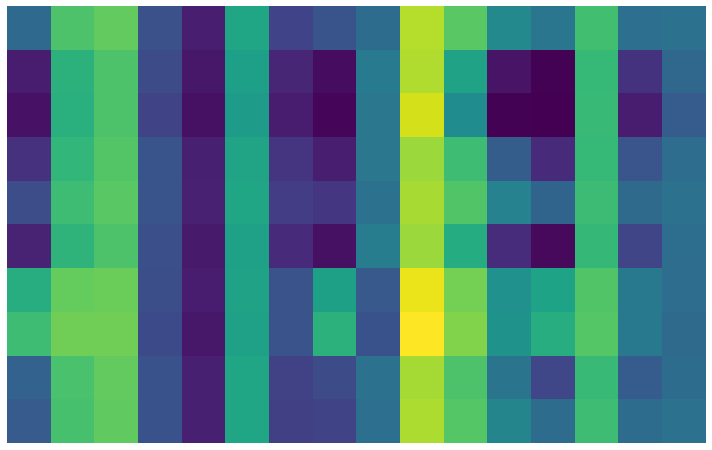

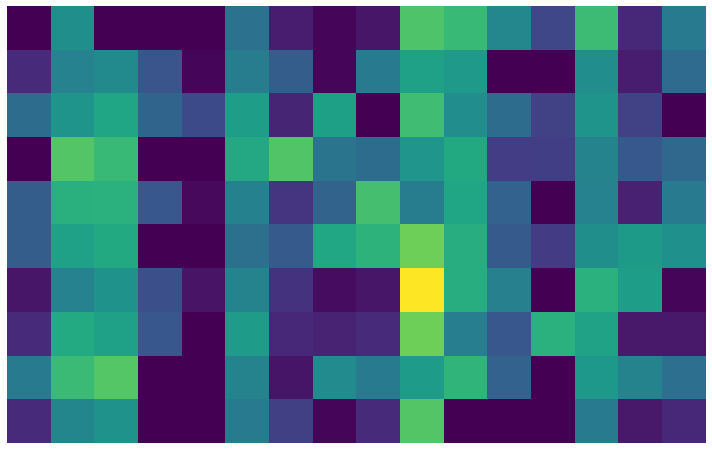

In [17]:
x = np.array([count / sum([X.shape[0] for X in train_per_label]) for count in [X.shape[0] for X in train_per_label]])
# L is the amount of data for each class that has to be generated
n_generated_per_class = np.round((1 - x) / (shapes["out_feat"] - 1) * n_generated_total).astype('int')
print(n_generated_per_class)
# generate new examples from normal distribution
z_rand = torch.empty(10, vae_z_dim).normal_(0, 1)
with torch.no_grad():
    x_gen = torch.cat([
        vae.decoder.forward(z_rand).reshape(-1, shapes["in_feat"])
        for vae in vae_per_label
    ], dim=1)
# plot
plt.figure(figsize=(10, 10), tight_layout=True)
plt.imshow(x_gen.numpy())
plt.axis("off")
plt.savefig(plot_dir / "vae_data.pdf")
plt.show()
plt.close()
# plot original
plt.figure(figsize=(10, 10), tight_layout=True)
plt.imshow(np.concatenate([X[:10].reshape(-1, shapes["in_feat"]) for X in train_per_label], axis=1))
plt.axis("off")
plt.savefig(plot_dir / "original_data.pdf")
plt.show()
plt.close()

Visualize Feature Space

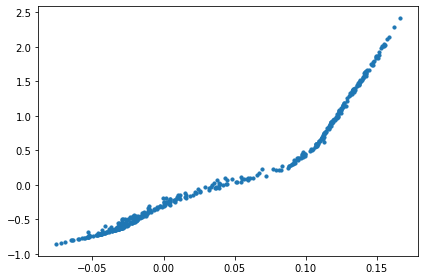

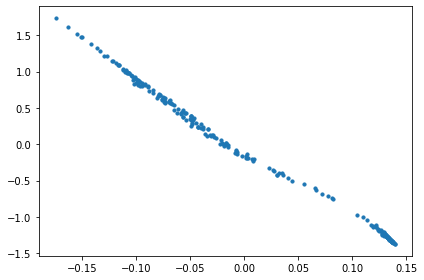

In [9]:
# encoded latent vectors of the dataset
with torch.no_grad():
    z_per_label = [vae.eval().encoder(torch.FloatTensor(x_train))[0].numpy() for vae, x_train in zip(vae_per_label, train_per_label)]

# plot the encoded latent vectors
for i, (vae, x_train, z) in enumerate(zip(vae_per_label, train_per_label, z_per_label)):
    # plot
    plt.figure(tight_layout=True)
    plt.scatter(z[:, 0], z[:, 1], s=10)
    (plot_dir / "feature_space").mkdir(exist_ok=True)
    plt.savefig(plot_dir / "feature_space" / f"class-{i}.pdf")
    plt.show()
    plt.close()

Learn Feature Space Structure for sampling

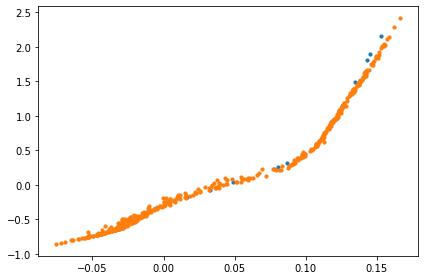

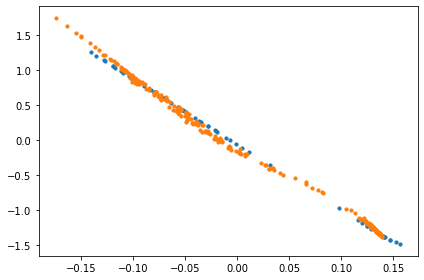

In [10]:
seed_everything(seed)
# create a mlp for each class to fit the latent space structure
mlp0 = MLPRegressor(
    hidden_layer_sizes=[1024],
    max_iter=200
)
mlp1 = MLPRegressor(
    hidden_layer_sizes=[1024],
    max_iter=200,
)

z0 = z_per_label[0]
z1 = z_per_label[1]

# train each mlp on latent vectors
mlp0.fit(z0[:, 1].reshape(-1,1), z0[:, 0])
mlp1.fit(z1[:, 0].reshape(-1,1), z1[:, 1])

# fit a kernel density function on the x (y) axis to know where to sample values from
kd0 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(z0[:, 1].reshape(-1,1))
kd1 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(z1[:, 0].reshape(-1,1))

def sample(n_generated0, n_generated1):
    seed_everything(seed)
    # sample new z latents
    z0x_rand = kd0.sample(n_generated0).reshape(-1, 1)
    z1x_rand = kd1.sample(n_generated1).reshape(-1, 1)
    # zx_rand_per_label = [np.random.uniform(-1, -4, size=n_generated_per_class), np.random.uniform(-1, -3, size=n_generated_per_class)]
    return [
        torch.FloatTensor(np.vstack([mlp0.predict(z0x_rand).reshape(-1), z0x_rand.reshape(-1)]).T),
        torch.FloatTensor(np.vstack([z1x_rand.reshape(-1), mlp1.predict(z1x_rand).reshape(-1)]).T),
    ]

z_rand_per_label = sample(*n_generated_per_class)

for i, (z, z_rand) in enumerate(zip(z_rand_per_label, z_per_label)):
    # plot
    plt.figure(tight_layout=True)
    plt.scatter(z[:, 0], z[:, 1], s=10)
    plt.scatter(z_rand[:, 0], z_rand[:, 1], s=10)
    (plot_dir / "feature_space").mkdir(exist_ok=True)
    plt.savefig(plot_dir / "feature_space" / f"sample-class-{i}.pdf")
    plt.show()
    plt.close()

## Generative Classifier

Train GC

In [11]:
seed_everything(seed)
gc = GenerativeClassifier(shapes["in_feat"], N=512, M=256, K=128)
gc, real_x, normal, uniform = train_gc2(
    train_per_label,
    vae_per_label,
    gc,
    gc_training_steps,
    gc_batch_size,
    gc_std,
    vae_z_dim,
    device,
)

100%|██████████| 800/800 [00:01<00:00, 478.64it/s]


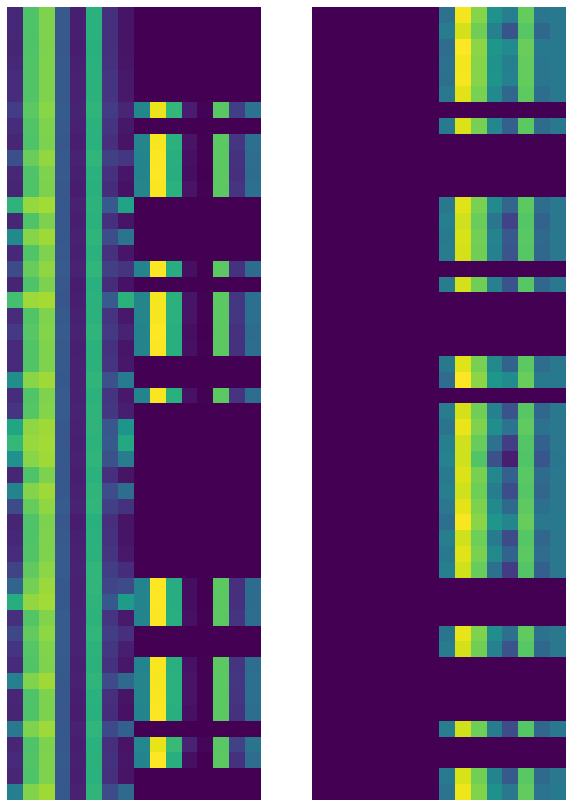

In [12]:
# visualize the data used to train the gc
_, (ax_good, ax_bad) = plt.subplots(1, 2, figsize=(10, 25))
ax_good.imshow(real_x[:50].numpy().reshape(1, 50, 1, 8).transpose(1, 2, 0, 3).reshape(50, 8))
ax_bad.imshow(normal[:50].numpy().reshape(1, 50, 1, 8).transpose(1, 2, 0, 3).reshape(50, 8))
ax_good.axis("off")
ax_bad.axis("off")
plt.savefig(plot_dir / "gc_train_data.pdf")
plt.close()

# generate some samples
with torch.no_grad():
    # z_rand = torch.empty(50, vae_z_dim).normal_(0, 1)
    z_rand_per_class = sample(50, 50)
    x_gen = torch.cat([
        vae.decoder.forward(z_rand)
        for vae, z_rand in zip(vae_per_label, z_rand_per_class)
    ], dim=0)
    # apply generative classifier
    mask = (gc.forward(x_gen) > 0.5).squeeze()
# convert to numpy
x_gen = x_gen.numpy()
mask = mask.numpy()
# apply mask
x_good, x_bad = x_gen.copy(), x_gen.copy()
x_good[~mask], x_bad[mask] = 0, 0

# visualize the choice of
# the generative classifier
_, (ax_good, ax_bad) = plt.subplots(1, 2, figsize=(10, 25))
ax_good.imshow(x_good.reshape(shapes["out_feat"], 50, 1, shapes["in_feat"]).transpose(1, 2, 0, 3).reshape(50, shapes["out_feat"] * shapes["in_feat"]))
ax_bad.imshow(x_bad.reshape(shapes["out_feat"], 50, 1, shapes["in_feat"]).transpose(1, 2, 0, 3).reshape(50, shapes["out_feat"] * shapes["in_feat"]))
ax_good.axis("off")
ax_bad.axis("off")
plt.savefig(plot_dir / "gc_good_bad.pdf")
plt.show()
plt.close()

# Training models

100%|██████████| 600/600 [00:01<00:00, 424.58it/s]


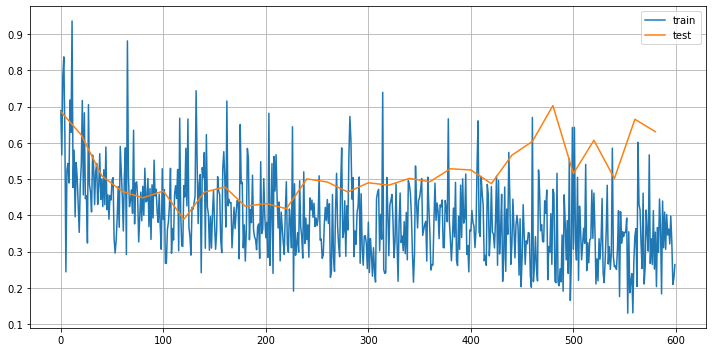

In [13]:
seed_everything(seed)
# build dataset of only the original samples
orig_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(train_per_label, axis=0)),
    torch.LongTensor(np.concatenate([
        (np.zeros(X.shape[0]) + i) for i, X in enumerate(train_per_label)
    ], axis=0))
)
# train model on dataset
model_orig = CNN(shapes["in_feat"], shapes["out_feat"], N=512, M=256, K=128)
model_orig, metrics_orig = train_classifier(
    orig_train_dataset,
    x_test,
    y_test,
    model_orig,
    cnn_training_steps,
    cnn_batch_size,
    cnn_eval_interval,
    vae_training_steps,
    device,
)
# plot the losses
plt.figure(figsize=(10, 5), tight_layout=True)
plt.grid()
plt.plot(metrics_orig['train-losses'], label='train')
ticks = [i * cnn_eval_interval for i in range(len(metrics_orig['test-losses']))]
plt.plot(ticks, metrics_orig['test-losses'], label='test')
plt.legend()
plt.savefig(plot_dir / "cnn_loss_orig.pdf")
plt.show()
plt.close()

100%|██████████| 600/600 [00:01<00:00, 459.11it/s]


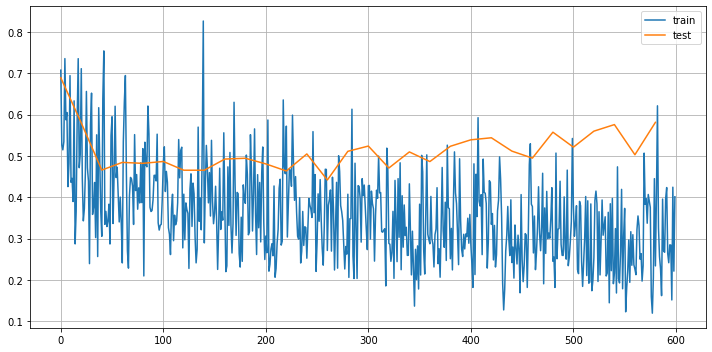

In [14]:
# build a dataset with both the original samples
# and also some generated ones using the vaes
# zx_rand_per_label = [np.random.uniform(-1, -4, size=n_generated_per_class), np.random.uniform(-1, -3, size=n_generated_per_class)]
z_rand_per_label = sample(*n_generated_per_class)
# seed_everything(seed)
with torch.no_grad():
    # z_rand_per_class = [torch.empty(n_generated, vae_z_dim).normal_(0, 1) for n_generated in n_generated_per_class]
    generated_per_label = [
        vae.decoder.forward(z_rand).numpy()
        for (vae, z_rand) in zip(vae_per_label, z_rand_per_class)
    ]
# create a combined dataset from the original and generated samples
full_train_x = [
    np.concatenate(both, axis=0)
    for both in zip(train_per_label, generated_per_label)
]
full_train_y = [
    (np.zeros(X.shape[:1]) + i) 
    for i, X in enumerate(full_train_x)
]
# pack all of this in a dataset
full_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(full_train_x, axis=0)),
    torch.LongTensor(np.concatenate(full_train_y, axis=0))
)
# train model on both original and generated data
model_gen = CNN(shapes["in_feat"], shapes["out_feat"], N=512, M=256, K=128)
model_gen, metrics_gen = train_classifier(
    full_train_dataset,
    x_test,
    y_test,
    model_gen,
    cnn_training_steps,
    cnn_batch_size,
    cnn_eval_interval,
    vae_training_steps,
    device,
)
# plot training and test losses
plt.figure(figsize=(10, 5), tight_layout=True)
plt.grid()
plt.plot(metrics_gen['train-losses'], label='train')
ticks = [i * cnn_eval_interval for i in range(len(metrics_gen['test-losses']))]
plt.plot(ticks, metrics_gen['test-losses'], label='test')
plt.legend()
plt.savefig(plot_dir / "cnn_loss_full.pdf")
plt.show()
plt.close()

  8%|▊         | 47/600 [00:00<00:01, 461.48it/s]

generated examples after gc:  [35, 20]


100%|██████████| 600/600 [00:01<00:00, 461.16it/s]


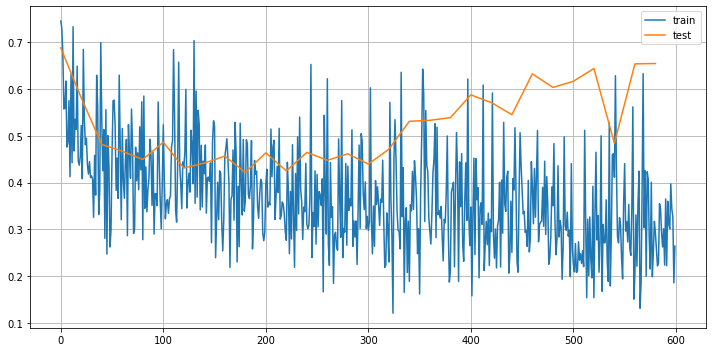

In [15]:
# build a dataset with both the original samples
# and also some generated ones using the vaes
# zx_rand_per_label = [np.random.uniform(-1, -4, size=n_generated_per_class), np.random.uniform(-1, -3, size=n_generated_per_class)]
z_rand_per_label = sample(*n_generated_per_class)
# seed_everything(seed)
with torch.no_grad():
    # z_rand_per_class = [torch.empty(n_generated * 30, vae_z_dim).normal_(0, 1) for n_generated in n_generated_per_class]
    generated_per_label = [
        vae.decoder.forward(z_rand)
        for (vae, z_rand) in zip(vae_per_label, z_rand_per_class)
    ]
    # apply generative classifier
    masks_per_label = [
        gc.forward(x_gen).flatten() > 0.5
        for x_gen in generated_per_label
    ]
    generated_per_label = [
        x_gen[mask, ...].numpy()[:n_generated, ...]
        for x_gen, mask, n_generated in zip(generated_per_label, masks_per_label, n_generated_per_class)
    ]
    print("generated examples after gc: ", [x_gen.shape[0] for x_gen in generated_per_label])

# create a combined dataset from the original and generated samples
full_train_x = [
    np.concatenate(both, axis=0)
    for both in zip(train_per_label, generated_per_label)
]
full_train_y = [
    (np.zeros(X.shape[:1]) + i) 
    for i, X in enumerate(full_train_x)
]
# pack all of this in a dataset
full_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(full_train_x, axis=0)),
    torch.LongTensor(np.concatenate(full_train_y, axis=0))
)
# train model on both original and generated data
model_gen_gc = CNN(shapes["in_feat"], shapes["out_feat"], N=512, M=256, K=128)
model_gen_gc, metrics_gen_gc = train_classifier(
    full_train_dataset,
    x_test,
    y_test,
    model_gen_gc,
    cnn_training_steps,
    cnn_batch_size,
    cnn_eval_interval,
    vae_training_steps,
    device,
)
# plot training and test losses
plt.figure(figsize=(10, 5), tight_layout=True)
plt.grid()
plt.plot(metrics_gen_gc['train-losses'], label='train')
ticks = [i * cnn_eval_interval for i in range(len(metrics_gen_gc['test-losses']))]
plt.plot(ticks, metrics_gen_gc['test-losses'], label='test')
plt.legend()
plt.savefig(plot_dir / "cnn_loss_gc.pdf")
plt.show()
plt.close()

Without Generated:	 0.8319
With Generated:		 0.8165
With Generated+GC:	 0.8182


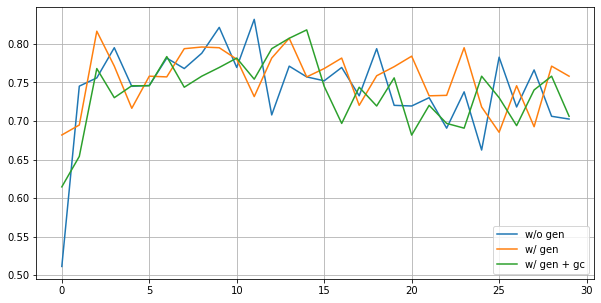

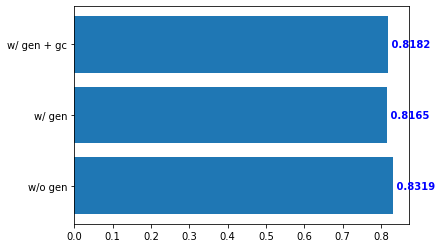

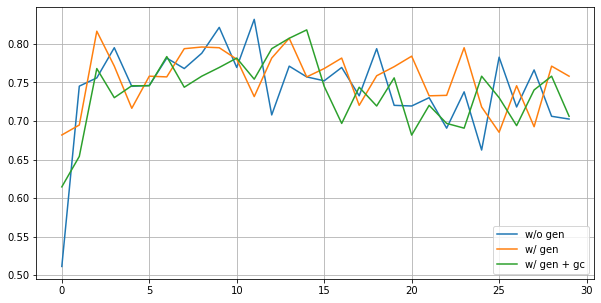

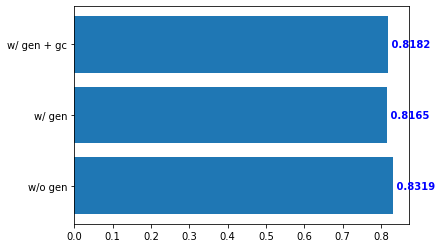

In [16]:
# append f1 scores of current cross-val-fold
all_f1_weighted_orig.append(metrics_orig['weighted-f1'])
all_f1_weighted_gen.append(metrics_gen['weighted-f1'])
all_f1_weighted_gen_gc.append(metrics_gen_gc['weighted-f1'])

# compare f1 scores of both models
print("Without Generated:\t", round(max(metrics_orig['weighted-f1']), 4))
print("With Generated:\t\t", round(max(metrics_gen["weighted-f1"]), 4))
print("With Generated+GC:\t", round(max(metrics_gen_gc["weighted-f1"]), 4))
# also plot
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(metrics_orig["weighted-f1"], label="w/o gen")
plt.plot(metrics_gen["weighted-f1"], label="w/ gen")
plt.plot(metrics_gen_gc["weighted-f1"], label="w/ gen + gc")
plt.legend()
plt.savefig(plot_dir / "weighted-f1.pdf")
plt.show()
plt.close()

y = [
    round(max(metrics_orig["weighted-f1"]), 4),
    round(max(metrics_gen["weighted-f1"]), 4),
    round(max(metrics_gen_gc["weighted-f1"]), 4),
]
plt.figure()    
plt.barh([0, 1, 2], y, tick_label=["w/o gen", "w/ gen", "w/ gen + gc"])
for i, v in enumerate(y):
    plt.text(v, i, f" {str(v)}", color="blue", va="center", fontweight="bold")
plt.savefig(plot_dir / "weighted-f1-max.pdf")
plt.show()
plt.close()

f1_weighted_orig = np.stack(all_f1_weighted_orig, axis=0)
f1_weighted_gen = np.stack(all_f1_weighted_gen, axis=0)
f1_weighted_gen_gc = np.stack(all_f1_weighted_gen_gc, axis=0)

plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(f1_weighted_orig.mean(axis=0), label="w/o gen")
plt.plot(f1_weighted_gen.mean(axis=0), label="w/ gen")
plt.plot(f1_weighted_gen_gc.mean(axis=0), label="w/ gen + gc")
plt.legend()
plt.savefig(plot_root / "weighted-f1.pdf")
plt.show()
plt.close()

y = [
    f1_weighted_orig.max(axis=1).mean().round(4),
    f1_weighted_gen.max(axis=1).mean().round(4),
    f1_weighted_gen_gc.max(axis=1).mean().round(4),
]
plt.figure()
plt.barh([0, 1, 2], y, tick_label=["w/o gen", "w/ gen", "w/ gen + gc"])
for i, v in enumerate(y):
    plt.text(v, i, f" {str(v)}", color="blue", va="center", fontweight="bold")
plt.savefig(plot_root / "weighted-f1-max.pdf")
plt.show()
plt.close()